In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import gc


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
file_path = '/content/drive/My Drive/Dataset/tweets.csv'
df = pd.read_csv(file_path, encoding='latin-1', header=None)

# Define column headers
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Convert target labels from 0 and 4 to 0 and 1
df['target'] = df['target'].replace(4, 1)

# Class balance check
print("\nClass Balance (Sentiment Labels):")
print(df['target'].value_counts())



Class Balance (Sentiment Labels):
target
0    800000
1    800000
Name: count, dtype: int64


In [ ]:
# Download NLTK resources
nltk.download('stopwords')

# Text Cleaning Function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Stemming
stemmer = SnowballStemmer("english")
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split()])
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=100)


In [ ]:
# Load pre-trained GloVe embeddings
glove_file_path = '/content/drive/My Drive/Dataset/glove.6B.100d.txt'
embedding_index = {}
embedding_dim = 100  # GloVe embedding dimensions

with open(glove_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefficients = np.array(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Prepare embedding matrix
vocab_size = min(5000, len(word_index)) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (5001, 100)


In [ ]:
# Define target labels
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [ ]:
# Define the LSTM model
input_layer = Input(shape=(100,), name='embedding_input')

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=100,
    weights=[embedding_matrix],
    trainable=False,
    name='embedding'
)(input_layer)

lstm1 = Bidirectional(LSTM(256, return_sequences=True), name='bidirectional')(embedding_layer)
dropout1 = Dropout(0.5, name='dropout')(lstm1)

lstm2 = Bidirectional(LSTM(256, return_sequences=True), name='bidirectional_1')(dropout1)
dropout2 = Dropout(0.5, name='dropout_1')(lstm2)

lstm3 = Bidirectional(LSTM(256), name='bidirectional_2')(dropout2)
dropout3 = Dropout(0.5, name='dropout_2')(lstm3)

dense1 = Dense(64, activation='relu', name='dense')(dropout3)
output_layer = Dense(1, activation='sigmoid', name='dense_1')(dense1)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with reduced learning rate
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_input (InputLayer)         │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 100)            │         500,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 512)            │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 512)            │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,413,957 (16.84 MB)

 Trainable params: 3,913,857 (14.93 MB)

 Non-trainable params: 500,100 (1.91 MB)

In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping]
)


Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 299s 36ms/step - accuracy: 0.7156 - loss: 0.5491 - val_accuracy: 0.7495 - val_loss: 0.5037
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 291s 36ms/step - accuracy: 0.7543 - loss: 0.4984 - val_accuracy: 0.7607 - val_loss: 0.4899
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 292s 36ms/step - accuracy: 0.7664 - loss: 0.4811 - val_accuracy: 0.7637 - val_loss: 0.4839
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 292s 36ms/step - accuracy: 0.7733 - loss: 0.4680 - val_accuracy: 0.7635 - val_loss: 0.4839
Epoch 5/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 293s 37ms/step - accuracy: 0.7813 - loss: 0.4546 - val_accuracy: 0.7634 - val_loss: 0.4890
Epoch 6/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 294s 37ms/step - accuracy: 0.7913 - loss: 0.4378 - val_accuracy: 0.7614 - val_loss: 0.4941
Epoch 7/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 294s 37ms/step - accuracy: 0.8016 - loss: 0.4208 - val_accuracy: 0.7601 - val_loss: 0.5031
Epoch 8/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 294s 37ms/step - accuracy: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 111s 11ms/step - accuracy: 0.7637 - loss: 0.4826

Test Loss: 0.4837
Test Accuracy: 0.7630


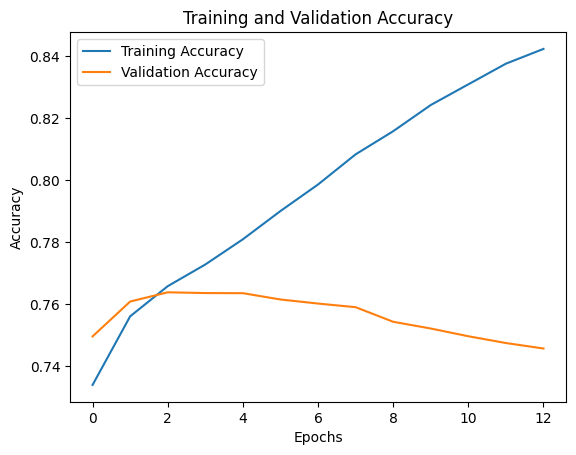

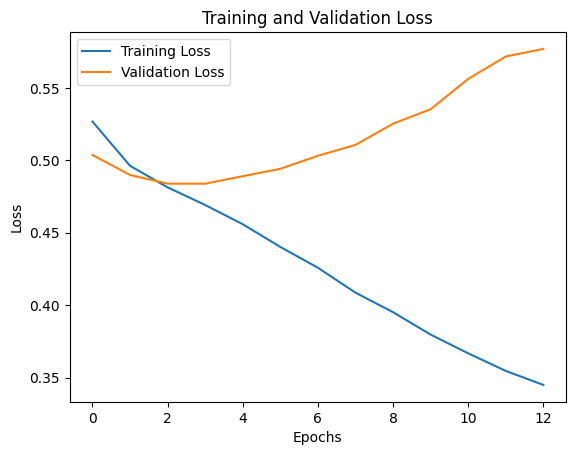

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
